In [1]:
# Explanation of prediction output when activation is sigmoid:
# https://forum.freecodecamp.org/t/model-predict-output/470349

import tensorflow as tf
import tensorflow_datasets as tfds
import logging, os
import pandas as pd
import time
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs/"
os.system("mkdir -p " + OUTPUT_PATH)


# Load the dataset
(train_dataset, validation_dataset), metadata = tfds.load(
    'cats_vs_dogs',
    data_dir=DATA_PATH,
    # split=['train[:80%]', 'train[80%:]'],
    # split=['train[:80%]', 'train[99%:]'],
    # split=['train[:5%]', 'train[5%:10%]'],
    split=['train[:20%]', 'train[20%:40%]'],
    with_info=True,
    as_supervised=True
)

print(f"Number of train samples: {train_dataset.cardinality()}")
print(f"Number of validation samples: {validation_dataset.cardinality()}")

# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

batch_size = 32
train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=10)


# Apply data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

train_dataset = train_dataset.map(augment)


# Model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2025-07-19 15:07:34.145710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-19 15:07:34.145743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-19 15:07:34.146587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 15:07:34.151565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-19 15:07:36.431708: I exter

Number of train samples: 4652
Number of validation samples: 4653


2025-07-19 15:07:36.431986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-19 15:07:36.493036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-19 15:07:36.493349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Train the model
epochs=10
history =model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset)

Epoch 1/10


2025-07-19 15:07:38.000189: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-19 15:07:39.163856: I external/local_xla/xla/service/service.cc:168] XLA service 0x7609a4cc7740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-19 15:07:39.163904: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-19 15:07:39.163918: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-19 15:07:39.174651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752955659.339640  421875 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 72/146 [=============>................] - ETA: 3s - loss: 1.7174 - accuracy: 0.5499

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 [==============================] - ETA: 0s - loss: 1.1946 - accuracy: 0.5587

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


146/146 [==============================] - 12s 59ms/step - loss: 1.1946 - accuracy: 0.5587 - val_loss: 0.6832 - val_accuracy: 0.6043
Epoch 2/10
146/146 [==============================] - 8s 51ms/step - loss: 0.6545 - accuracy: 0.6322 - val_loss: 0.6006 - val_accuracy: 0.6862
Epoch 3/10
146/146 [==============================] - 8s 54ms/step - loss: 0.5585 - accuracy: 0.7225 - val_loss: 0.5853 - val_accuracy: 0.7034
Epoch 4/10
146/146 [==============================] - 8s 51ms/step - loss: 0.4487 - accuracy: 0.7945 - val_loss: 0.5916 - val_accuracy: 0.7041
Epoch 5/10
146/146 [==============================] - 8s 52ms/step - loss: 0.3296 - accuracy: 0.8654 - val_loss: 0.6236 - val_accuracy: 0.7011
Epoch 6/10
146/146 [==============================] - 7s 51ms/step - loss: 0.2601 - accuracy: 0.9043 - val_loss: 0.6794 - val_accuracy: 0.7148
Epoch 7/10
146/146 [==============================] - 8s 52ms/step - loss: 0.1983 - accuracy: 0.9273 - val_loss: 0.6988 - val_accuracy: 0.6995
Epoch 8/1

Text(0.5, 1.0, 'Training and validation loss')

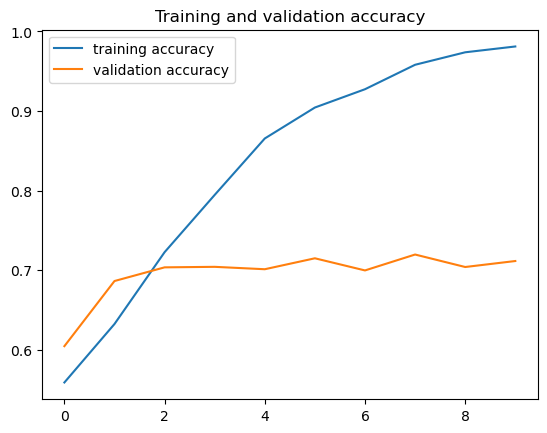

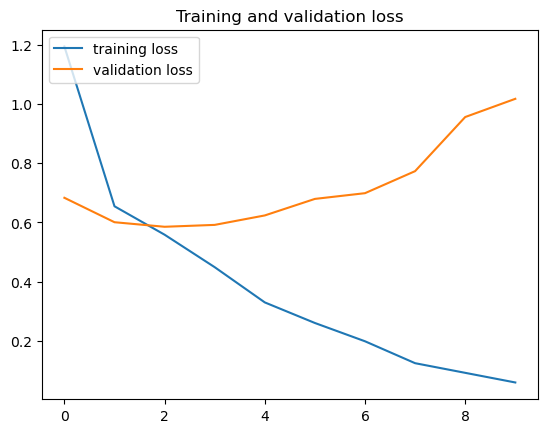

In [3]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_plot   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     acc , label="training accuracy")
plt.plot  ( epochs_plot, val_acc, label="validation accuracy" )
plt.title ('Training and validation accuracy')
plt.legend(loc="upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     loss , label="training loss")
plt.plot  ( epochs_plot, val_loss , label="validation loss" )
plt.legend(loc="upper left")
plt.title ('Training and validation loss'   )

In [4]:
# Make predictions
predictions = model.predict(validation_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)

alllabels=np.empty(0)
for images, labels in validation_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("test dataset accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_fit.csv", index=False)   

  8/146 [>.............................] - ETA: 1s 

146/146 [==============================] - 1s 8ms/step
test dataset accuracy score: 0.7113690092413497
        l      pred  pnorm  diff
0     1.0  0.999981      1   0.0
1     0.0  0.270359      0   0.0
2     1.0  0.322350      0   1.0
3     0.0  0.995108      1  -1.0
4     0.0  0.048995      0   0.0
...   ...       ...    ...   ...
4648  1.0  0.063255      0   1.0
4649  1.0  0.861176      1   0.0
4650  0.0  0.035739      0   0.0
4651  0.0  0.982288      1  -1.0
4652  0.0  0.000762      0   0.0

[4653 rows x 4 columns]


In [5]:
# Save model
timestr = time.strftime("%Y%m%d-%H%M%S")
acc=val_acc[-1] # last element
filename = f"valacc_{score:.3f}_epochs_{epochs}_date_{timestr}.h5"
fullpath = f"{OUTPUT_PATH}{filename}"
print("Saving model to ", filename)
model.save(fullpath)

Saving model to  valacc_0.711_epochs_10_date_20250719-150859.h5


/media/data/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
